# GCAMP8 loading notebook

When using `stim_with_pup.mat` as the stimuli, you can vary the frequency of the stimulus and gray presentation, controlled by some parameters in the script, those parameters are multiples of ~3Hz, so if you increase the sampling frequency of the recording (in this case ~13Hz) you want to roughly match the stimulus presentation with the neural frames.

In the case of this recording the parameters on `stim_with_pup.mat` were setted to **4**, since the sampling frequency of the recording was **13 Hz**

In this example notebook I modified the `get_neurons_atframes()` function to allow binning

In [3]:
import sys # os stands for "operating system" and includes read/write routines etc. 
import mkl
from src import utils # this is our own library of functions
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import pandas as pd

sns.set_context("talk")
mkl.set_num_threads(10)
sys.path.insert(0,r'C:\Users\WinDesktopMP\Documents\suite2p')
%matplotlib inline
%load_ext autoreload
%autoreload 2

c:\Users\WinDesktopMP\anaconda3\envs\suite2p\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No module named 'cellpose'
cannot use anatomical mode, but otherwise suite2p will run normally


In [4]:
exp_db = []
exp_db = utils.add_exp(exp_db,"L1_A4","2022_08_22","1")

In [5]:
timeline  = utils.load_exp_info(exp_db[0], timeline_block=None)
spks, xpos, ypos, iplane, stat, ops = utils.load_neurons(exp_db[0], dual_plane=True, baseline=True)

planes: 4


100%|██████████| 4/4 [04:16<00:00, 64.09s/it]

total neurons: 13952


In [6]:
def get_neurons_atframes_w_bin(timeline, spks, bin=4):
    """
    Get the neurons at each frame, and the subset of stimulus before the recording ends.

    Parameters
    ----------
    spks : array
        Spikes of the neurons.
    Timeline : array
        Timeline of the experiment.

    Returns
    -------
    neurons_atframes : array
        Neurons at each frame.
    subset_stim: array
        Stimuli before recording ends
    """
    def rolling_window(a,win_size=bin,freq=bin):
        return np.lib.stride_tricks.sliding_window_view(a,win_size)[::freq,:].mean(1)

    if bin is None:
        _, nt = spks.shape
        tlag = 1  # this is the normal lag between frames and stimuli
        istim = timeline["stiminfo"].item()["istim"]
        frame_start = timeline["stiminfo"].item()["frame_start"]
        frame_start = np.array(frame_start).astype("int")
        frame_start0 = frame_start + tlag
        ix = frame_start0 < nt
        frame_start0 = frame_start0[ix]
        neurons_atframes = spks[
            :, frame_start0
        ]  # sample the neurons at the stimulus frames
        subset_stim = istim[ix]
    else:
        _, nt = spks.shape
        tlag = 1  # this is the normal lag between frames and stimuli
        istim = timeline["stiminfo"].item()["istim"]
        frame_start = timeline["stiminfo"].item()["frame_start"]
        frame_start = np.array(frame_start).astype("int")
        frame_start0 = frame_start + tlag
        ix = frame_start0 < nt
        frame_start0 = frame_start0[ix]
        n_stim_frames = len(frame_start0)
        frames_to_bin = np.empty((0,n_stim_frames*bin),int)
        for stim_frame in range(n_stim_frames):
            effective_frames = np.arange(frame_start0[stim_frame],frame_start0[stim_frame]+bin)
            frames_to_bin = np.append(frames_to_bin, [effective_frames])
        frames_to_bin = frames_to_bin[frames_to_bin<nt]
        neurons_atframes_tobin = spks[:, frames_to_bin]
        neurons_atframes = np.apply_along_axis(rolling_window, 1, neurons_atframes_tobin)  # bin the neurons using specified bin
        subset_stim = istim[ix][:neurons_atframes.shape[1]]
    return neurons_atframes, subset_stim

In [7]:
neurons_atframes, subset_stim = get_neurons_atframes_w_bin(timeline, spks, bin=4)
neurons_atframes_nobin, subset_stim_nobin = get_neurons_atframes_w_bin(timeline, spks, bin=None)

first 1000 frames of neuron 0:

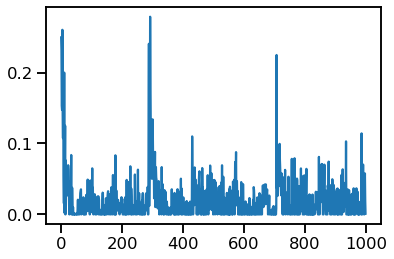

In [8]:
plt.plot(neurons_atframes[0,:1000])

In [10]:
avg_res, csig = utils.get_tuned_neurons(neurons_atframes, subset_stim)
print(f"signal variance with bin=4 : {csig.mean()}")
avg_res_nobin, csig_nobin = utils.get_tuned_neurons(neurons_atframes_nobin, subset_stim_nobin)
print(f"signal variance with no bin : {csig_nobin.mean()}")

signal variance with bin=4 : 0.15040256083011627
signal variance with no bin : 0.03120078518986702
